In [6]:
%load_ext autoreload
%autoreload 2

In [5]:
from folktables import ACSDataSource, ACSIncome

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)

In [7]:
from folktables.acs import adult_filter
from folktables import BasicProblem
import numpy as np

feature_names = [
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ]

target='PINCP'

ACSIncome_outcome = BasicProblem(
    features=feature_names,
    target=target,
    #target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=adult_filter,
    #postprocess=lambda x: np.nan_to_num(x, -1),
)

In [8]:
features, label, group = ACSIncome_outcome.df_to_numpy(acs_data)

In [9]:
continuous_attributes = ['AGEP', 'WKHP']

In [10]:
feature_names = [
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ]

categorical_attributes = list(set(feature_names)-set(continuous_attributes))

In [11]:
import pandas as pd


df = pd.DataFrame(features, columns=feature_names)
df["income"] = label
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,48500.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,7700.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,17200.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,12000.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,300.0


# Remap columns

In [12]:
import pandas as pd
import os
filename = os.path.join(os.path.curdir, "datasets", "ACSPUMS", "PUMS_Data_Dictionary_2018.csv")

In [13]:
df_mappings = pd.read_csv(filename)

In [14]:
remapping_cols = {}

In [15]:
orig_col = "1"
new_col = "Record Type"
cols_i = [orig_col, new_col]

#col_name = "OCCP"
for col_name in categorical_attributes:
    dict_i = df_mappings.loc["VAL"].loc[col_name][cols_i].set_index(orig_col).to_dict()[new_col]
    dict_i = {float(k) if (k not in ["b", "bb", 'bbbb']) else -1 :v for k,v in dict_i.items()}
    remapping_cols[col_name] = dict_i

In [16]:
from copy import deepcopy

df_renamed = deepcopy(df)

for column_name in remapping_cols:
    df_renamed[column_name] = df[column_name].replace(remapping_cols[column_name])

In [17]:
df_renamed.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,Self-employed in own not incorporated business...,Grade 11,Married,TRN-Cleaners Of Vehicles And Equipment,California/CA,Institutionalized group quarters population,40.0,Male,Some Other Race alone,48500.0
1,21.0,State government employee,Regular high school diploma,Never married or under 15 years old,"SCI-Other Life, Physical, And Social Science T...",California/CA,Noninstitutionalized group quarters population,20.0,Male,White alone,7700.0
2,65.0,"Employee of a private not-for-profit, tax-exem...",Master's degree,Never married or under 15 years old,CMS-Clergy,California/CA,Noninstitutionalized group quarters population,8.0,Male,White alone,17200.0
3,33.0,Employee of a private for-profit company or bu...,Grade 11,Divorced,TRN-Cleaners Of Vehicles And Equipment,New York/NY,Institutionalized group quarters population,40.0,Male,White alone,12000.0
4,18.0,"Employee of a private not-for-profit, tax-exem...","1 or more years of college credit, no degree",Never married or under 15 years old,CMM-Software Developers,California/CA,Noninstitutionalized group quarters population,18.0,Female,White alone,300.0


In [18]:
import pickle

with open(
    os.path.join(os.path.curdir, "datasets", "ACSPUMS", "census_column_mapping.pickle"),
    "wb",
) as fp:
    pickle.dump(remapping_cols, fp)

In [19]:
from copy import deepcopy

df_analysis = deepcopy(df_renamed)

In [20]:
df_analysis.to_csv(os.path.join(os.path.curdir, "datasets", "ACSPUMS", "adult_dataset_income.csv"), index=False)

In [22]:
continuous_attributes = ['AGEP', 'WKHP']

In [23]:
df_analysis.shape

(195665, 11)

# Tree divergence - income - individual

## Tree

In [24]:
df_analysis.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,Self-employed in own not incorporated business...,Grade 11,Married,TRN-Cleaners Of Vehicles And Equipment,California/CA,Institutionalized group quarters population,40.0,Male,Some Other Race alone,48500.0
1,21.0,State government employee,Regular high school diploma,Never married or under 15 years old,"SCI-Other Life, Physical, And Social Science T...",California/CA,Noninstitutionalized group quarters population,20.0,Male,White alone,7700.0
2,65.0,"Employee of a private not-for-profit, tax-exem...",Master's degree,Never married or under 15 years old,CMS-Clergy,California/CA,Noninstitutionalized group quarters population,8.0,Male,White alone,17200.0
3,33.0,Employee of a private for-profit company or bu...,Grade 11,Divorced,TRN-Cleaners Of Vehicles And Equipment,New York/NY,Institutionalized group quarters population,40.0,Male,White alone,12000.0
4,18.0,"Employee of a private not-for-profit, tax-exem...","1 or more years of college credit, no degree",Never married or under 15 years old,CMM-Software Developers,California/CA,Noninstitutionalized group quarters population,18.0,Female,White alone,300.0


In [25]:
min_support = 0.1

In [26]:
metric = "d_outcome"


target = "income"

In [29]:
from tree_discretization_ranking import TreeDiscretization_ranking

tree_discr = TreeDiscretization_ranking()


type_experiment = "one_at_time"

type_criterion = "weighted_sum_abs_reference_s"


generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analysis,
    type_splitting=type_experiment,
    min_support=0.1,
    metric=metric,
    continuous_attributes= list(continuous_attributes),
    storeTree=True,
    type_criterion = type_criterion,
    minimal_gain = 0.0,
    target_col = target
)
tree_discr.printDiscretizationTrees()

dot = {}
for attribute in continuous_attributes:
    if attribute in tree_discr.trees:
        dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph()

AGEP
 root s=1.00000 --> d_outcome=0.00000
         AGEP<=34.0 s=0.34457 --> d_outcome=-27955.56992
                 AGEP<=26.0 s=0.17018 --> d_outcome=-43910.89461
                 AGEP>=27.0 s=0.17439 --> d_outcome=-12385.07707
         AGEP>=35.0 s=0.65543 --> d_outcome=14696.92523
                 AGEP<=45.0 s=0.21916 --> d_outcome=10078.50061
                         AGEP<=39.0 s=0.10386 --> d_outcome=7210.72910
                         AGEP>=40.0 s=0.11530 --> d_outcome=12661.65597
                 AGEP>=46.0 s=0.43627 --> d_outcome=17016.93116
                         AGEP<=62.0 s=0.33538 --> d_outcome=15335.39768
                                 AGEP<=56.0 s=0.22501 --> d_outcome=15754.23832
                                         AGEP<=51.0 s=0.12260 --> d_outcome=15066.80999
                                         AGEP>=52.0 s=0.10241 --> d_outcome=16577.21059
                                 AGEP>=57.0 s=0.11037 --> d_outcome=14481.48255
                         AGEP>=63.0

In [30]:
from tree_discretization_ranking import TreeDiscretization_ranking

tree_discr = TreeDiscretization_ranking()


type_experiment = "one_at_time"

type_criterion = "weighted_sum_abs_reference_s"


generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analysis,
    type_splitting=type_experiment,
    min_support=0.1,
    metric=metric,
    continuous_attributes= list(continuous_attributes),
    storeTree=True,
    type_criterion = type_criterion,
    minimal_gain = None,
    target_col = target
)
tree_discr.printDiscretizationTrees()

dot = {}
for attribute in continuous_attributes:
    if attribute in tree_discr.trees:
        dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph()

AGEP
 root s=1.00000 --> d_outcome=0.00000
         AGEP<=34.0 s=0.34457 --> d_outcome=-27955.56992
                 AGEP<=26.0 s=0.17018 --> d_outcome=-43910.89461
                 AGEP>=27.0 s=0.17439 --> d_outcome=-12385.07707
         AGEP>=35.0 s=0.65543 --> d_outcome=14696.92523
                 AGEP<=45.0 s=0.21916 --> d_outcome=10078.50061
                         AGEP<=39.0 s=0.10386 --> d_outcome=7210.72910
                         AGEP>=40.0 s=0.11530 --> d_outcome=12661.65597
                 AGEP>=46.0 s=0.43627 --> d_outcome=17016.93116
                         AGEP<=62.0 s=0.33538 --> d_outcome=15335.39768
                                 AGEP<=56.0 s=0.22501 --> d_outcome=15754.23832
                                         AGEP<=51.0 s=0.12260 --> d_outcome=15066.80999
                                         AGEP>=52.0 s=0.10241 --> d_outcome=16577.21059
                                 AGEP>=57.0 s=0.11037 --> d_outcome=14481.48255
                         AGEP>=63.0

In [31]:
generalization_dict

{'AGEP': {'<=26.0': '<=34.0',
  '[27.0-34.0]': '<=34.0',
  '[35.0-45.0]': '>=35.0',
  '[35.0-39.0]': '[35.0-45.0]',
  '[40.0-45.0]': '[35.0-45.0]',
  '>=46.0': '>=35.0',
  '[46.0-62.0]': '>=46.0',
  '[46.0-56.0]': '[46.0-62.0]',
  '[46.0-51.0]': '[46.0-56.0]',
  '[52.0-56.0]': '[46.0-56.0]',
  '[57.0-62.0]': '[46.0-62.0]',
  '>=63.0': '>=46.0'},
 'WKHP': {'<=29.0': '<=39.0',
  '[30.0-39.0]': '<=39.0',
  '[40.0-43.0]': '>=40.0',
  '>=44.0': '>=40.0'}}

In [32]:
discretizations

{'AGEP': {'<=26.0': {'rels': ['<='], 'vals': [26.0]},
  '[27.0-34.0]': {'rels': ['>=', '<='], 'vals': [27.0, 34.0]},
  '[35.0-39.0]': {'rels': ['>=', '<='], 'vals': [35.0, 39.0]},
  '[40.0-45.0]': {'rels': ['>=', '<='], 'vals': [40.0, 45.0]},
  '[46.0-51.0]': {'rels': ['>=', '<='], 'vals': [46.0, 51.0]},
  '[52.0-56.0]': {'rels': ['>=', '<='], 'vals': [52.0, 56.0]},
  '[57.0-62.0]': {'rels': ['>=', '<='], 'vals': [57.0, 62.0]},
  '>=63.0': {'rels': ['>='], 'vals': [63.0]}},
 'WKHP': {'<=29.0': {'rels': ['<='], 'vals': [29.0]},
  '[30.0-39.0]': {'rels': ['>=', '<='], 'vals': [30.0, 39.0]},
  '[40.0-43.0]': {'rels': ['>=', '<='], 'vals': [40.0, 43.0]},
  '>=44.0': {'rels': ['>='], 'vals': [44.0]}}}

## min_sup_divergence  = 0.1

### Without Generalization 

In [33]:
import pandas as pd
pd.set_option('max_colwidth', None)

In [34]:
INFO = ['support', 'itemsets', 'tn', 'fp', 'fn', 'tp', 'd_fpr', 't_value_fp', 'error']

In [35]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=0.1,
    apply_generalization=False,
    #true_class_name=pred_name,
    #predicted_class_name=class_name,
    target_name = target,
    #class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = ["d_outcome"],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

In [36]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
99,0.133723,"(WKHP=>=44.0, MAR=Married)",2,26165.0,127980.685419,62788.636601,73.243438
166,0.100856,"(WKHP=>=44.0, SEX=Male, RAC1P=White alone)",3,19734.0,126960.907267,61768.858449,62.426454
111,0.120783,"(WKHP=>=44.0, RELP=Reference person)",2,23633.0,122340.421191,57148.372373,66.907892
77,0.149828,"(WKHP=>=44.0, RAC1P=White alone)",2,29316.0,118337.261018,53145.212200,69.055758
86,0.144129,"(WKHP=>=44.0, SEX=Male)",2,28201.0,118197.353782,53005.304964,65.825654


In [37]:
from utils_discretization import discretizeDataset_from_relations
allow_overalp = False if type_experiment!="all_attributes" else True
df_s_discretized, discretized_attr = discretizeDataset_from_relations(
    df_analysis, discretizations, ret_original_attrs=False, allow_overalp=allow_overalp
)
df_s_discretized.head()

,COW,SCHL,MAR,OCCP,POBP,RELP,SEX,RAC1P,income,AGEP,WKHP
0,"Self-employed in own not incorporated business, professional practice, or farm",Grade 11,Married,TRN-Cleaners Of Vehicles And Equipment,California/CA,Institutionalized group quarters population,Male,Some Other Race alone,48500.0,[27.0-34.0],[40.0-43.0]
1,State government employee,Regular high school diploma,Never married or under 15 years old,"SCI-Other Life, Physical, And Social Science Technicians",California/CA,Noninstitutionalized group quarters population,Male,White alone,7700.0,<=26.0,<=29.0
2,"Employee of a private not-for-profit, tax-exempt, or charitable organization",Master's degree,Never married or under 15 years old,CMS-Clergy,California/CA,Noninstitutionalized group quarters population,Male,White alone,17200.0,>=63.0,<=29.0
3,"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",Grade 11,Divorced,TRN-Cleaners Of Vehicles And Equipment,New York/NY,Institutionalized group quarters population,Male,White alone,12000.0,[27.0-34.0],[40.0-43.0]
4,"Employee of a private not-for-profit, tax-exempt, or charitable organization","1 or more years of college credit, no degree",Never married or under 15 years old,CMM-Software Developers,California/CA,Noninstitutionalized group quarters population,Female,White alone,300.0,<=26.0,<=29.0


In [38]:
len(FP_fm)

172

In [39]:
tree_discr.get_number_nodes()

(8, 12)

In [40]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
99,0.133723,"(WKHP=>=44.0, MAR=Married)",2,26165.0,127980.685419,62788.636601,73.243438
166,0.100856,"(WKHP=>=44.0, SEX=Male, RAC1P=White alone)",3,19734.0,126960.907267,61768.858449,62.426454
111,0.120783,"(WKHP=>=44.0, RELP=Reference person)",2,23633.0,122340.421191,57148.372373,66.907892
77,0.149828,"(WKHP=>=44.0, RAC1P=White alone)",2,29316.0,118337.261018,53145.212200,69.055758
86,0.144129,"(WKHP=>=44.0, SEX=Male)",2,28201.0,118197.353782,53005.304964,65.825654


In [41]:
FP_fm.loc[FP_fm["length"]==1].head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
1,0.653234,"(COW=Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions)",1,127815.0,62750.279185,-2441.769633,7.961690
2,0.618435,(RAC1P=White alone),1,121006.0,70750.551394,5558.502576,16.840013
3,0.527999,(SEX=Male),1,103311.0,76401.610071,11209.561252,30.832910
4,0.523558,(MAR=Married),1,102442.0,82394.162590,17202.113771,46.843295
5,0.482713,(POBP=California/CA),1,94450.0,57412.700286,-7779.348532,24.974586


In [42]:
FP_fm.sort_values("length", ascending = True).head(1)

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
0,1.0,(),0,195665.0,65192.048818,0.0,0.0


In [43]:
df_analysis["income"].describe()["mean"]

65192.04881813304

### With Generalization 

In [44]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=0.1,
    apply_generalization=True,
    #true_class_name=pred_name,
    #predicted_class_name=class_name,
    target_name = target,
    #class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = ["d_outcome"],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

In [45]:
len(FP_fm)

536

In [46]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
410,0.112917,"(WKHP=>=44.0, MAR=Married, AGEP=>=35.0)",3,22094.0,136027.741649,70835.692831,73.301853
470,0.106355,"(SEX=Male, WKHP=>=44.0, AGEP=>=35.0)",3,20810.0,135897.798847,70705.750029,70.461299
413,0.112452,"(WKHP=>=44.0, AGEP=>=35.0, RAC1P=White alone)",3,22003.0,134322.412126,69130.363307,73.065519
474,0.104965,"(AGEP=>=46.0, WKHP=>=44.0)",2,20538.0,129593.183562,64401.134744,65.807872
286,0.133723,"(WKHP=>=44.0, MAR=Married)",2,26165.0,127980.685419,62788.636601,73.243438


In [47]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
410,0.112917,"(WKHP=>=44.0, MAR=Married, AGEP=>=35.0)",3,22094.0,136027.741649,70835.692831,73.301853
470,0.106355,"(SEX=Male, WKHP=>=44.0, AGEP=>=35.0)",3,20810.0,135897.798847,70705.750029,70.461299
413,0.112452,"(WKHP=>=44.0, AGEP=>=35.0, RAC1P=White alone)",3,22003.0,134322.412126,69130.363307,73.065519
474,0.104965,"(AGEP=>=46.0, WKHP=>=44.0)",2,20538.0,129593.183562,64401.134744,65.807872
286,0.133723,"(WKHP=>=44.0, MAR=Married)",2,26165.0,127980.685419,62788.636601,73.243438


In [48]:
len(FP_fm)

536

# Tree divergence - income - combined

## Tree

In [49]:
df_analysis.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,"Self-employed in own not incorporated business, professional practice, or farm",Grade 11,Married,TRN-Cleaners Of Vehicles And Equipment,California/CA,Institutionalized group quarters population,40.0,Male,Some Other Race alone,48500.0
1,21.0,State government employee,Regular high school diploma,Never married or under 15 years old,"SCI-Other Life, Physical, And Social Science Technicians",California/CA,Noninstitutionalized group quarters population,20.0,Male,White alone,7700.0
2,65.0,"Employee of a private not-for-profit, tax-exempt, or charitable organization",Master's degree,Never married or under 15 years old,CMS-Clergy,California/CA,Noninstitutionalized group quarters population,8.0,Male,White alone,17200.0
3,33.0,"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",Grade 11,Divorced,TRN-Cleaners Of Vehicles And Equipment,New York/NY,Institutionalized group quarters population,40.0,Male,White alone,12000.0
4,18.0,"Employee of a private not-for-profit, tax-exempt, or charitable organization","1 or more years of college credit, no degree",Never married or under 15 years old,CMM-Software Developers,California/CA,Noninstitutionalized group quarters population,18.0,Female,White alone,300.0


In [50]:
continuous_attributes = ['AGEP', 'WKHP']

In [51]:
min_support = 0.1

In [52]:
metric = "d_outcome"

target = "income"

In [53]:
minimal_gain = 0

Splits
False
Type splitting: None
 root s=1.00000 --> d_outcome=0.00000
         WKHP<=39.0 s=0.30499 --> d_outcome=-33031.20637
                 AGEP<=34.0 s=0.13592 --> d_outcome=-49881.86178
                 AGEP>=35.0 s=0.16907 --> d_outcome=-19485.28018
         WKHP>=40.0 s=0.69501 --> d_outcome=14495.07145
                 WKHP<=43.0 s=0.47721 --> d_outcome=590.71838
                         AGEP<=35.0 s=0.16371 --> d_outcome=-18263.15271
                         AGEP>=36.0 s=0.31351 --> d_outcome=10435.96631
                                 RELP=Reference person s=0.17567 --> d_outcome=18040.85765
                                 RELP!=Reference person s=0.13783 --> d_outcome=743.24763
                 WKHP>=44.0 s=0.21780 --> d_outcome=44960.98870
                         AGEP<=43.0 s=0.10322 --> d_outcome=23985.31551
                         AGEP>=44.0 s=0.11458 --> d_outcome=63856.77780


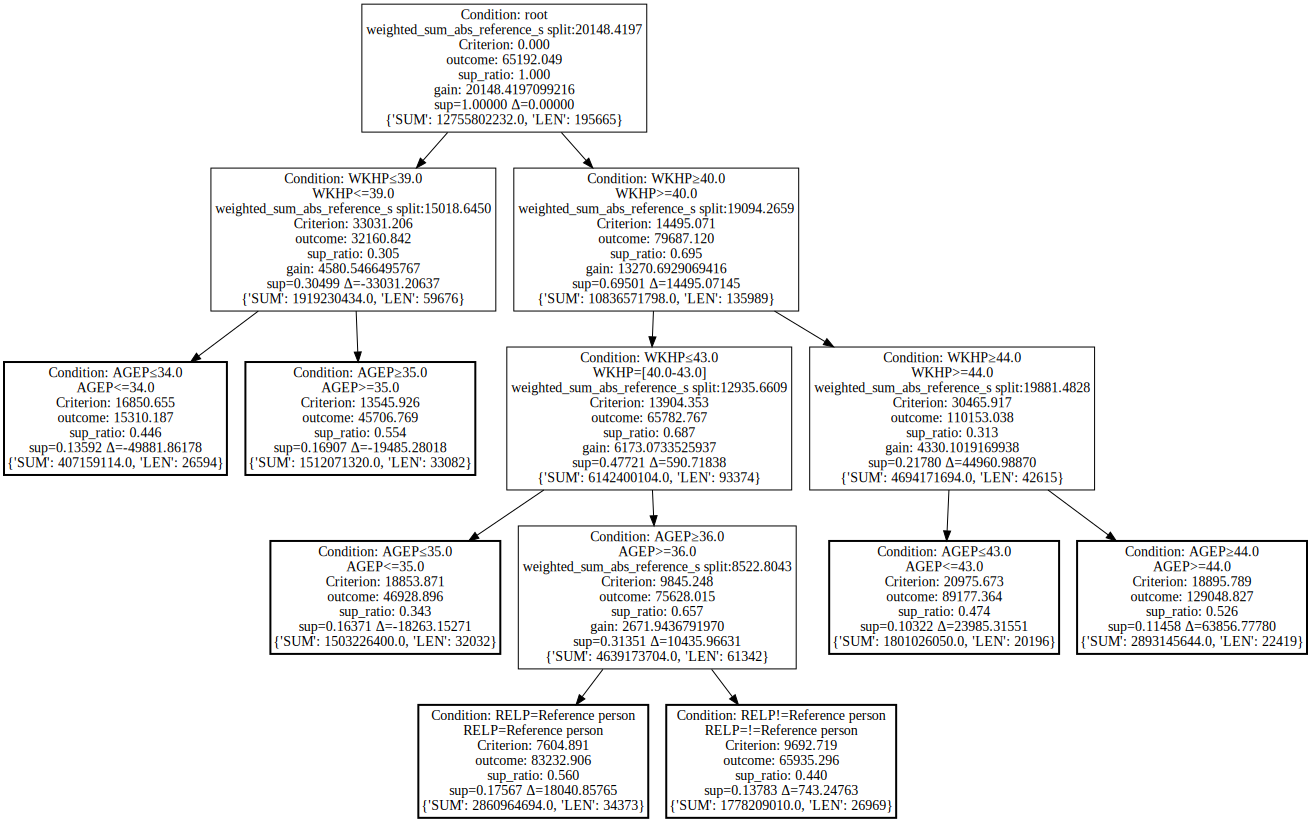

In [54]:
from tree_discretization_ranking import TreeDiscretization_ranking

tree_discr = TreeDiscretization_ranking()


type_experiment = "all_attributes"

type_criterion = "weighted_sum_abs_reference_s"


generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analysis,
    type_splitting=type_experiment,
    min_support=0.1,
    metric=metric,
    #class_map=class_map,
    continuous_attributes= list(continuous_attributes),
    #class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion = type_criterion,
    minimal_gain = minimal_gain,
    target_col = target
)
tree_discr.printDiscretizationTrees()

tree_discr.trees.visualizeTreeDiGraph()

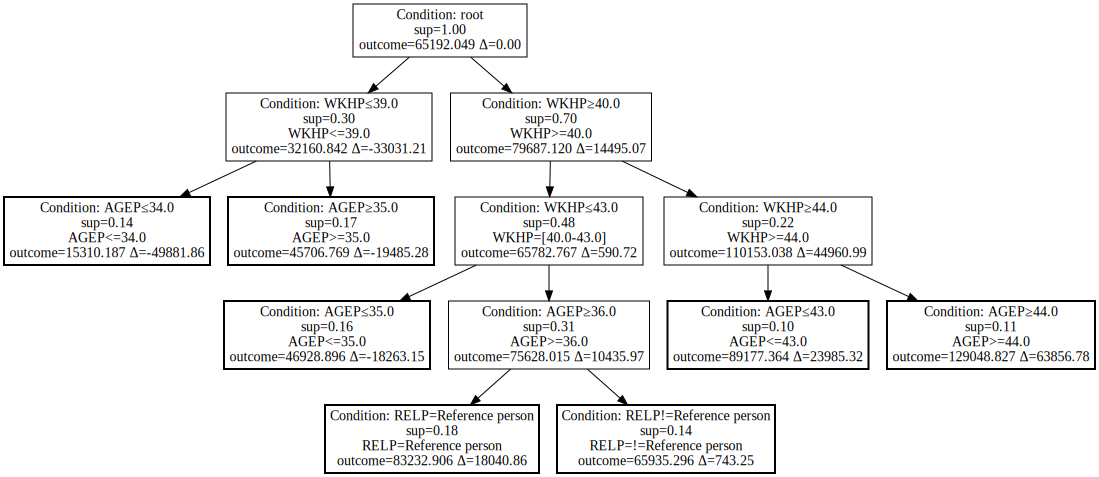

In [55]:
tree_discr.trees.visualizeTreeDiGraph(all_info = False)

In [59]:
tree_discr.get_number_nodes()

(5, 7)

## min_sup_divergence  = 0.1

In [60]:
df_analysis["income"].describe()["mean"]

65192.04881813304

In [61]:
allow_overalp = (
    True if type_experiment == "all_attributes" else False
)
allow_overalp

True

### With Generalization 

In [74]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

FP_fm_True = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=0.1,
    apply_generalization=True,
    #true_class_name=pred_name,
    #predicted_class_name=class_name,
    target_name = target,
    #class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = ["d_outcome"],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

In [63]:
len(FP_fm_True)

1347

In [64]:
FP_fm_True.sort_values(metric, ascending = False).head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
1267,0.102870,"(WKHP=>=44.0, SEX=Male, AGEP=>=36.0)",3,20128.0,136866.079293,71674.030474,69.923427
1265,0.102870,"(WKHP=>=44.0, SEX=Male, AGEP=>=36.0, WKHP=>=40.0)",4,20128.0,136866.079293,71674.030474,69.923427
1264,0.102870,"(AGEP=>=35.0, WKHP=>=40.0, WKHP=>=44.0, AGEP=>=36.0, SEX=Male)",5,20128.0,136866.079293,71674.030474,69.923427
1266,0.102870,"(SEX=Male, WKHP=>=44.0, AGEP=>=35.0, AGEP=>=36.0)",4,20128.0,136866.079293,71674.030474,69.923427
1097,0.109672,"(AGEP=>=35.0, WKHP=>=40.0, WKHP=>=44.0, MAR=Married, AGEP=>=36.0)",5,21459.0,136644.643926,71452.595107,72.611023


In [65]:
len(FP_fm_True)

1347

## min_sup_divergence  = 0.05

In [66]:
df_analysis["income"].describe()["mean"]

65192.04881813304

In [67]:
allow_overalp = (
    True if type_experiment == "all_attributes" else False
)
allow_overalp

True

### With Generalization 

In [75]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

FP_fm_True = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=0.05,
    apply_generalization=True,
    target_name = target,
    FPM_type="fpgrowth",
    metrics_divergence = ["d_outcome"],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

In [70]:
FP_fm_True.sort_values(metric, ascending = False).head()

,support,itemsets,length,support_count,outcome,d_outcome,t_value_outcome
3756,0.055774,"(RAC1P=White alone, WKHP=>=44.0, MAR=Married, AGEP=>=36.0, SEX=Male)",5,10913.0,156034.659947,90842.611129,61.541257
3757,0.055774,"(AGEP=>=35.0, RAC1P=White alone, WKHP=>=44.0, MAR=Married, AGEP=>=36.0, SEX=Male)",6,10913.0,156034.659947,90842.611129,61.541257
3755,0.055774,"(RAC1P=White alone, WKHP=>=40.0, WKHP=>=44.0, MAR=Married, AGEP=>=36.0, SEX=Male)",6,10913.0,156034.659947,90842.611129,61.541257
3754,0.055774,"(AGEP=>=35.0, WKHP=>=40.0, RAC1P=White alone, WKHP=>=44.0, MAR=Married, AGEP=>=36.0, SEX=Male)",7,10913.0,156034.659947,90842.611129,61.541257
3581,0.057287,"(AGEP=>=35.0, RAC1P=White alone, WKHP=>=44.0, MAR=Married, SEX=Male)",5,11209.0,155382.353823,90190.305005,62.047340


In [71]:
len(FP_fm_True)

4467